
## 一、编写爬虫程序过程中遇到的问题及解决方法：

### 1. 问题：固定休眠时间触发反爬

### 解决方法：最初以为西安二手房成交房源信息高达近6万套，爬取数据会需要很长时间，故计划只采集未央区的1万多套房源。却发现即使数据并不太多的情况下，若休眠时间固定，当程序只剩余后面的几千条数据时，也会因为触发反爬机制而被中断。故修改休眠时间为随机而非固定，成功解决问题。

### 2. 问题：仅爬取未央区的1万多套房源，还是整个西安市的近6万套？

### 解决方法：在第1个问题的解决过程中意外发现，只要休眠时间随机，即使休眠时间很短，如只有十几秒，依然不会触发反爬。因此决定爬取西安市的近6万套房源，并设定随机休眠时间为1-2分钟。

### 3. 问题：总价和单价的正则表达式总是无法匹配到目标数据

### 解决方法：不断修改正则表达式，尽量比较短，以及减少换行造成的匹配失败。
    
### 4. 问题：总价和单价的正则表达式在最简和能匹配上时完全相同，数据写入时难以识别二者区别

### 解决方法：使用索引定位
    
                    totalprice = re.findall(findTotalPrice, item)[0]
                    unitprice = re.findall(findUnitPrice, item)[1]
            
### 5. 问题：由于少量房源下架，导致成交总价缺失，信息匹配不到，而使得第4个问题中的索引定位超出范围，程序无法运行
### 解决方法：使用try-except进行异常处理，重排添加数据的顺序
    
                try:      # 有个别房源因为下架，没有总价数据，使用try-except进行异常处理
                    totalprice = re.findall(findTotalPrice, item)[0]
                    unitprice = re.findall(findUnitPrice, item)[1]
                    data.append(totalprice)  # 添加成交总价
                    data.append(unitprice)   #添加成交单价
                except IndexError:
                    if int(re.findall(findTotalPrice, item)[0]) < 1000:
                        data.append(re.findall(findTotalPrice, item))
                        data.append("0")
                    else:
                        data.append("0")
                        data.append(re.findall(findTotalPrice, item))
                        
### 6. 问题：因爬取数据多，且区域分布非常不均匀，而每组数据最多只显示30页，即3000条，分更小区域爬取会造成url复杂无规律

### 解决方法：按照价格自定义区间设定爬取数据组，分成24组，每组2500条左右数据，这样baseurl和newurl都好设置。
    

# 爬虫代码：

In [1]:
from bs4 import BeautifulSoup   # 网页解析，获取数据
import re     # 正则表达式，进行文字匹配
import urllib.request,urllib.error  # 制定url，获取网页数据
import xlwt    # 进行excel操作
import random
import time


def main(a):
    baseurl = "https://xa.ke.com/chengjiao/"
    # 1.爬取网页
    datalist = getdata(baseurl)
    # 3.保存数据
    savepath = "西安二手房成交信息.xls"
    savedata(datalist, savepath)


# 1房源名称
findId = re.compile(r'target="_blank">(.*?)</a>')
# 2房源链接
findLink = re.compile(r'href="(.*?)"')
# 3房源朝向+装修
findInofIcon = re.compile(r'<span class="houseIcon"></span>(.*?)</div>', re.S)
# 4房源成交单价
findUnitPrice = re.compile(r'<span class="number">(\d*)</span>')
# 5房源成交总价
findTotalPrice = re.compile(r'<span class="number">(\d*)</span>')
# 6房源成交周期
findCycle = re.compile(r'<span>成交周期(\d*)天</span>')
# 7挂牌价
findListPrice = re.compile(r'<span>挂牌(.*?)万</span>')
# 8房源楼层
findLevel = re.compile(r'<span class="positionIcon"></span>(.*?)</div>', re.S)
# 9房源满几
findYears = re.compile(r'<span>房屋满(.*?)年</span>')
# 10房源位置
findPosition = re.compile(r'<span>(距.*?)</span>')
# 11成交日期
findDealDate = re.compile(r'<div class="dealDate">(.*?)</div>', re.S)


def getdata(baseurl):
    datalist = []
    priceRanges = {
        "p1": 61,     # 40万以下的房源
        "bp40ep50": 52,   # 40-50万的房源，以下为相应价格区间
        "bp50ep60": 91,
        "bp60ep65": 59,
        "bp65ep71": 73,
        "bp71ep79": 92,
        "bp79ep87": 94,
        "bp87ep95": 92,
        "bp95ep102": 89,
        "bp102ep108": 91,
        "bp108ep114": 90,
        "bp114ep119": 87,
        "bp119ep124": 85,
        "bp124ep130": 94,
        "bp130ep136": 88,
        "bp136ep143": 88,
        "bp143ep150": 74,
        "bp150ep157": 68,
        "bp157ep165": 63,
        "bp165ep180": 95,
        "bp180ep199": 84,
        "bp199ep230": 88,
        "bp230ep300": 89,
        "p8": 69,      # 300万以上的房源
    }
    for price, pg_sum in priceRanges.items():
        print(price,"总共%d页"%pg_sum)
        for i in range(1, pg_sum+1):
            url = baseurl + "pg" + str(i) + price + "/"
            # print(i, url)
            html = askurl(url)      # 获取网页源码

            # 2.逐一解析数据
            soup = BeautifulSoup(html, "html.parser")
            for item in soup.find_all('div', class_="info", limit=30):  # 查找符合要求的所有字符串，形成列表
                # print(item)    # 测试查看一套房源item全部信息
                data = []        # data列表用于保存一套房源的所有信息
                item = str(item)

                # 保存一套房源的详细信息
                id = re.findall(findId, item)
                data.append(id)  # 1添加房源Id
                link = re.findall(findLink, item)
                data.append(link)  # 2添加房源链接
                orientation = re.findall(findInofIcon, item)
                data.append(orientation)  # 3添加房源朝向和装修情况
                try:      # 有个别房源因为下架，没有总价数据，使用try-except进行异常处理
                    totalprice = re.findall(findTotalPrice, item)[0]
                    unitprice = re.findall(findUnitPrice, item)[1]
                    data.append(totalprice)  # 添加成交总价
                    data.append(unitprice)   #添加成交单价
                except IndexError:
                    if int(re.findall(findTotalPrice, item)[0]) < 1000:
                        data.append(re.findall(findTotalPrice, item))
                        data.append("0")
                    else:
                        data.append("0")
                        data.append(re.findall(findTotalPrice, item))
                cycle = re.findall(findCycle, item)
                data.append(cycle)  # 6添加房源成交周期
                listprice = re.findall(findListPrice, item)
                data.append(listprice)  # 7添加房源挂牌价
                level = re.findall(findLevel, item)
                data.append(level)  # 8添加房源楼层
                years = re.findall(findYears, item)
                if years != 0:
                    data.append(years)  # 9添加房屋满几年信息
                else:
                    data.append(" ")  # 9若没有房屋满几年信息，留空
                position = re.findall(findPosition, item)
                if position != 0:
                    data.append(position)  # 10添加房屋位置信息
                else:
                    data.append(" ")  # 10若没有房屋位置信息，留空
                dealdate = re.findall(findDealDate, item)
                data.append(dealdate)  # 11添加交易日期

                # print(data)
                datalist.append(data)  # 把处理好的套房源信息存于datalist中
        print("已爬取%d条房源数据"%len(datalist))
        sleeptime = (random.randint(60, 120))
        print("睡眠", sleeptime/60, "分钟...............")
        time.sleep(sleeptime)       # 每爬取2500左右的一组数据，随机睡眠1-2两分钟
    return datalist


def askurl(url):
    User_Agent= [
        "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Trident/4.0; InfoPath.2; .NET4.0C; .NET4.0E; .NET CLR 2.0.50727; 360SE) ",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Trident/4.0; SE 2.X MetaSr 1.0; SE 2.X MetaSr 1.0; .NET CLR 2.0.50727; SE 2.X MetaSr 1.0)",
        "Mozilla/5.0 (Windows NT 5.1; zh-CN; rv:1.9.1.3) Gecko/20100101 Firefox/8.0",
        "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_8; en-us) AppleWebKit/534.50 (KHTML, like Gecko) Version/5.1 Safari/534.50",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Maxthon 2.0)",
        "Opera/9.80 (Windows NT 6.1; U; en) Presto/2.8.131 Version/11.11",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Trident/4.0; TencentTraveler 4.0; .NET CLR 2.0.50727)",
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36"
        ]
    headers = {"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
                "Accept - Encoding": "gzip, deflate, br",
                "Accept - Language": "zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6",
                "Cache - Control": "max-age=0",
                "Connection": "keep-alive",
                "Cookie": "lianjia_uuid=b64378bb-79f5-4521-b44f-7eeb4d677191; select_city=610100; Hm_lvt_9152f8221cb6243a53c83b956842be8a=1610088406,1611116495,1611142021,1611219120; sensorsdata2015jssdkcross=%7B%22distinct_id%22%3A%22176e0bf8ee9b5-0bd23fc8f76b1a-5a301e44-921600-176e0bf8eea3f8%22%2C%22%24device_id%22%3A%22176e0bf8ee9b5-0bd23fc8f76b1a-5a301e44-921600-176e0bf8eea3f8%22%2C%22props%22%3A%7B%22%24latest_traffic_source_type%22%3A%22%E7%9B%B4%E6%8E%A5%E6%B5%81%E9%87%8F%22%2C%22%24latest_referrer%22%3A%22%22%2C%22%24latest_referrer_host%22%3A%22%22%2C%22%24latest_search_keyword%22%3A%22%E6%9C%AA%E5%8F%96%E5%88%B0%E5%80%BC_%E7%9B%B4%E6%8E%A5%E6%89%93%E5%BC%80%22%2C%22%24latest_utm_source%22%3A%22baidu%22%2C%22%24latest_utm_medium%22%3A%22pinzhuan%22%2C%22%24latest_utm_campaign%22%3A%22wyxian%22%2C%22%24latest_utm_content%22%3A%22biaotimiaoshu%22%2C%22%24latest_utm_term%22%3A%22biaoti%22%7D%7D; Hm_lpvt_9152f8221cb6243a53c83b956842be8a=1611220132; srcid=eyJ0Ijoie1wiZGF0YVwiOlwiNWM1OWE0NjRmMjc0MzhjZDEzNTViYTdmZDc4NGFkNWRmZDkyMTI4ZTdhOWMzNGJjMWIyYmMwNzc5OTAzMjYxNWY4ZDQ3ZjkyOTVmZjQ1MGRkY2EzZTkyMzhiMTZhNzM3NzkwYmJhZmM0Yjg5MzA4NjJkMDc3ZWU2ZTE0MDlhMmUwZjBkMzQwODk5MWRmODk2NDcwMTYwNTNlMjdjM2I2ODJmYjA5YTQxNjQyZWJlMWM0NzE3MzRjMGJmM2UwZWNiODcwNTZiYjIxODEzNjc4NmYxNWU4ZDYzZDBhN2FkYWI4MGRjNDg3MTM1NmM4YzI1MWM0MzNlNzg2YTBhYmNlYmJjMmVlMzUzYTg4ODhmMWMyM2VjYThiOTQ0NWYxMjMzYWE2NmRkYzY2YWQzYTIxYzg0NzExOWQzYjY4YTgxNDcyZDU0N2NjZGY4ZWNjNDBiYzNiNDY3NjBhMTAyNzc4NVwiLFwia2V5X2lkXCI6XCIxXCIsXCJzaWduXCI6XCI5NTcyN2Y4NVwifSIsInIiOiJodHRwczovL3hhLmtlLmNvbS9jaGVuZ2ppYW8vd2VpeWFuZy9wOC8iLCJvcyI6IndlYiIsInYiOiIwLjEifQ==",
                "Host": "xa.ke.com",
                "Referer": "https://xa.ke.com/chengjiao/",
                "Sec - Fetch - Dest": "document",
                "Sec - Fetch - Mode": "navigate",
                "Sec - Fetch - Site": "same - origin",
                "Sec - Fetch - User": "?1",
                "Upgrade - Insecure - Requests": "1",
                "User - Agent": random.choice(User_Agent)     # 随机选用列表待选的user-Agent,伪装成从不同浏览器访问
               }
    request = urllib.request.Request(url, headers=headers)
    html = ""
    try:
        response = urllib.request.urlopen(request)
        html = response.read().decode("utf-8")
    except urllib.error.URLError as e:
        if hasattr(e,"code"):
            print(e.code)
        if hasattr(e,"reason"):
            print(e.reason)

    return html


# 3.保存数据
def savedata(datalist, savepath):
    print("saving......")
    book = xlwt.Workbook(encoding="utf-8", style_compression=8)  #创建workbook对象
    sheet = book.add_sheet("西安市未央区二手房成交信息", cell_overwrite_ok=True)   #创建工作表
    col = ("小区 户型 面积", "房源链接", "朝向 装修情况", "成交总价", "成交单价" , "成交周期", "挂牌价", "楼层", "满二满五情况", "交通便利度", "交易日期")

    for i in range(0, 11):
        sheet.write(0, i, col[i])  # 列名
    for i in range(0, len(datalist)):
        # print("第%d条" % (i+1))
        data = datalist[i]
        for j in range(0, 11):
            sheet.write(i+1, j, data[j])   # 数据
            for j in range(0, 11):
                sheet.write(i+1, j, data[j])

    book.save(savepath)  # 保存数据

if __name__ == '__main__':
    # 调用函数
    main(2)
    print("爬取完毕")


p1 总共61页
已爬取1830条房源数据
睡眠 1.0666666666666667 分钟...............
bp40ep50 总共52页
已爬取3375条房源数据
睡眠 1.35 分钟...............
bp50ep60 总共91页
已爬取6091条房源数据
睡眠 1.5166666666666666 分钟...............
bp60ep65 总共59页
已爬取7861条房源数据
睡眠 1.8666666666666667 分钟...............
bp65ep71 总共73页
已爬取10051条房源数据
睡眠 1.7 分钟...............
bp71ep79 总共92页
已爬取12803条房源数据
睡眠 1.0166666666666666 分钟...............
bp79ep87 总共94页
已爬取15623条房源数据
睡眠 1.95 分钟...............
bp87ep95 总共92页
已爬取18383条房源数据
睡眠 2.0 分钟...............
bp95ep102 总共89页
已爬取21052条房源数据
睡眠 1.7166666666666666 分钟...............
bp102ep108 总共91页
已爬取23782条房源数据
睡眠 1.5833333333333333 分钟...............
bp108ep114 总共90页
已爬取26477条房源数据
睡眠 1.6 分钟...............
bp114ep119 总共87页
已爬取29087条房源数据
睡眠 1.2666666666666666 分钟...............
bp119ep124 总共85页
已爬取31623条房源数据
睡眠 1.5 分钟...............
bp124ep130 总共94页
已爬取34443条房源数据
睡眠 1.35 分钟...............
bp130ep136 总共88页
已爬取37083条房源数据
睡眠 1.4833333333333334 分钟...............
bp136ep143 总共88页
已爬取39664条房源数据
睡眠 1.6333333333333333 分钟.........

## 二、数据可视化

## 1. 爬取的房源数据部分展示：

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


import pandas as pd
data = pd.read_excel("xianershoufang.xlsx", index_col='id')
print(data.head())      # 展示excel文件的头部信息
print(data.tail())      # 展示excel文件的尾部信息

        小区    户型  面积（平米）  成交总价（万）  成交单价（元/平）  成交周期（天）  挂牌价（万）         楼层  \
id                                                                         
1     金辉悦府    车位   15.00        9       6000       62    13.0         车位   
2   金泰假日花城    车位   26.39       25       9474      192    26.0         车位   
3    维也纳森林  2室1厅   36.09       28       7759       17    28.0  中楼层(共12层)   
4    裕昌太阳城    车位   30.38       20       6584       82    21.0         车位   
5      浪琴湾    车位   15.00       10       6667      167    11.5         车位   

   建造年份、房屋类型 交通便利度        交易日期                                           房源链接  \
id                                                                              
1   2016年建平房   NaN  2021.01.09  https://xa.ke.com/chengjiao/101109774046.html   
2         平房   NaN  2021.01.09  https://xa.ke.com/chengjiao/101108305417.html   
3       板塔结合   NaN  2021.01.09  https://xa.ke.com/chengjiao/101110164376.html   
4         平房   NaN  2021.01.09  https://xa.ke.com/chengjiao/10

## 2. 西安二手房成交信息中热词词云和西安市最受欢迎小区词云：

<Figure size 432x288 with 0 Axes>

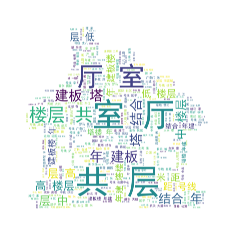

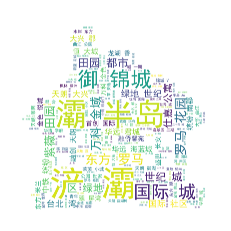

<Figure size 432x288 with 0 Axes>

In [38]:

from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import jieba    
from wordcloud import WordCloud, STOPWORDS


# 读取整个文件
file1 = open(path.join('西安二手房成交信息.txt')).read()   # 西安二手房成交信息表中的文字text
file2 = open(path.join('西安小区名.txt')).read()     # 西安二手房成交信息表的小区名称text

##进行分词
default_mode1 =jieba.cut(file1)
default_mode2 =jieba.cut(file2)
text1 = " ".join(default_mode1)
text2 = " ".join(default_mode2)
alice_mask = np.array(Image.open(path.join("房子.jpg")))
wc1 = WordCloud(
    #设置字体，不指定就会出现乱码,这个字体文件需要下载
    font_path=r'fonts/simhei.ttf',
    scale=10,
    background_color="white",
    max_words=2000,
    mask=alice_mask,)
wc2 = WordCloud(
    #设置字体，不指定就会出现乱码,这个字体文件需要下载
    font_path=r'fonts/simhei.ttf',
    scale=10,
    background_color="white",
    max_words=2000,
    mask=alice_mask,)
# generate word cloud
wc1.generate(text1)
wc2.generate(text2)
# store to file
wc1.to_file(path.join("西安二手房词云.jpg"))
wc2.to_file(path.join("西安最受欢迎小区词云.jpg"))
# show
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.figure()
# plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
# plt.axis("off")
# plt.show()

## 3. 西安市二手房户型分布比例、成交单价排名top20、大户型小区排名top20：

西安市二手房成交数量最多和最少小区：
东方罗马花园           714
华远君城             399
融侨馨苑             396
仕嘉公寓A区（绿地世纪城）    385
恒大城              373
                ... 
崇业路8号院             1
红福小区               1
香米园正街              1
镜湖居                1
永丰公寓               1
Name: 小区, Length: 2948, dtype: int64


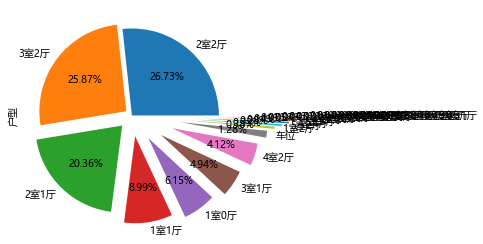

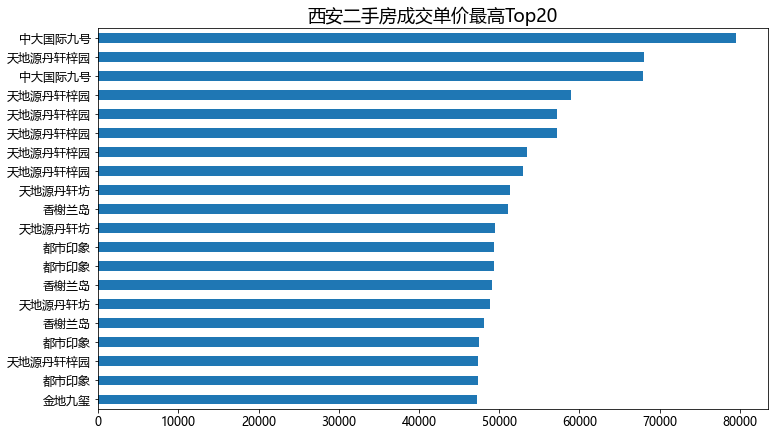

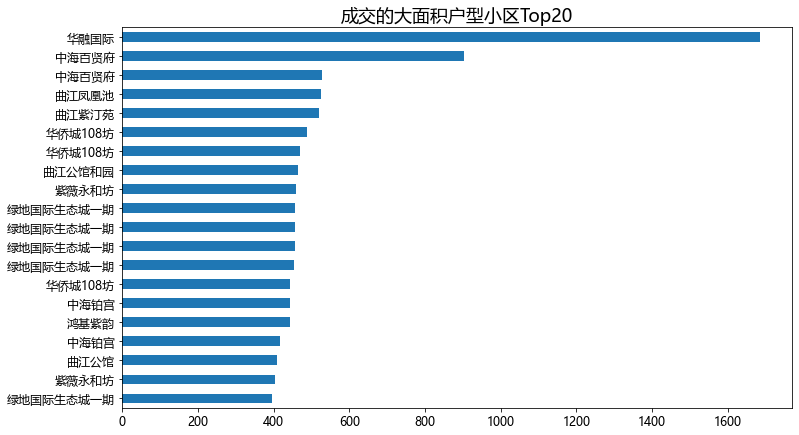

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
data = pd.read_excel("xianershoufang.xlsx", index_col='id')
# print(data.head())

#输出西安市成交房源数最多的小区和最少的小区
print('西安市二手房成交数量最多和最少小区：')
print(data['小区'].value_counts())


# 绘制户型占比饼图
data["户型"].value_counts().plot(kind="pie", autopct="%1.2f%%", explode=np.linspace(0,2.5,32))
plt.show()


# 西安二手房成交单价最高Top20柱状图
unitprice_top = data.sort_values(by="成交单价（元/平）",ascending=False)[:20]
unitprice_top = unitprice_top.sort_values(by="成交单价（元/平）")
unitprice_top.set_index(unitprice_top["小区"],inplace=True)
unitprice_top.index.name = ""
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.set_ylabel("单价(元/平米)",fontsize=14)
ax.set_title("西安二手房成交单价最高Top20",fontsize=18)
unitprice_top["成交单价（元/平）"].plot(kind="barh",fontsize=12)
plt.show()


# 成交的大面积户型小区Top20
unitprice_top = data.sort_values(by="面积（平米）",ascending=False)[:20]
unitprice_top = unitprice_top.sort_values(by="面积（平米）")
unitprice_top.set_index(unitprice_top["小区"],inplace=True)
unitprice_top.index.name = ""
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.set_ylabel("面积（平米）",fontsize=14)
ax.set_title("成交的大面积户型小区Top20",fontsize=18)
unitprice_top["面积（平米）"].plot(kind="barh",fontsize=12)
plt.show()